# Evaluate Plots V2

test pair에 대한 iteration을 수행한다.

1. pickle을 통해서 모든 아이템을 다 읽는다.
2. 현재 source sequence를 읽는다.
3. scene similarity를 읽는다.
- mistral로 계산한 inclusion ratio
- 직접 계산한 entity similarity

4. action sequence similarity를 계산한다.
- agent4 필터 통과와 상관없이 플롯
- agent4 필터를 통과하면 플롯

5. activity taxnomy similarity를 계산한다.
- agent4 필터 통과와 상관없이 플롯
- agent4 필터를 통과하면 플롯


다음의 pandas colum을 구성한다. (568x13 정도 되나?)

없는 곳은 None표시를 한다.

source idx, target idx, 
augmentation_id, inclusion_ratio, entity_similarity
goal_category, goal_description
core activity_gt, core activity_inf
sequence sim, taxonomy sim
sequence bool, taxonomy bool

In [2]:
# %matplotlib qt
import sys
import os
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
import mplcursors
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from bert_score import score

import pickle

sys.path.append(os.path.abspath('/root/project')) # add root path to sys.path
sys.path.append(os.path.abspath('/usr/local/lib/python3.10/dist-packages'))
from util import util_constants
from util import util_funcs
import f4_evaluate.evaluate_scene as evaluate_scene
import f1_init.database_init as database_init
import f1_init.agent_init as agent_init
import f1_init.constants_init as constants_init

#Computing similarity
import json
from sentence_transformers import SentenceTransformer
from bert_score import score
import numpy as np
from numpy.linalg import norm
import ast
import pandas as pd

#PATHS
PATH_CURR_FOLDER = os.path.abspath('') 
PATH_DATA_ANNOTATION = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_annotation'))
PATH_DATA_INPUT_OUTPUT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output'))
PATH_SOURCE_TARGET_INPUT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/input/source_target_video_list.pkl'))
TEST_SPATIAL_ANNOTATION_PATH_MANUAL = PATH_DATA_ANNOTATION + '/spatial_testset/manual'

#PAIRSIM DATA
PATH_PAIRSIM = PATH_DATA_ANNOTATION + '/spatial_pairsim_result'

#AUGMENTED DATA PATH
TEST_SPATIAL_ANNOTATION_PATH_SEMI = PATH_DATA_ANNOTATION + '/spatial_testset/semi'    
TEST_SPATIAL_ANNOTATION_V2_PATH = PATH_DATA_ANNOTATION + '/spatial_augmentation/TESTSET_Augmented_Data_v2/'

#BASELINE RESULT PATHS
PATH_BASELINE_RAG = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-rag/'))
PATH_BASELINE_NORAG = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-norag/'))
PATH_BASELINE_1DIRECT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-1direct/'))
PATH_BASELINE_1GOALMEDIATION = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output/output-1goalmediation/'))




/root/project/data/ego4d_annotation/goalstep/
all: goalstep vids: 717
all: spatial vids: 211
dbinit: testuid excluded: goalstep vids: 646
dbinit: testuid excluded: spatial vids: 140
dbinit: testuid list: test goalstep vids: 71
dbinit: testuid list: test spatial vids: 71
dbinit: MAKE_DOCU: goalstep_document_list: 38613
dbinit: MAKE_DOCU: goalstep_document_list: 1366
dbinit: MAKE_DOCU: spatial_document_list: 1243
dbinit: MAKE_DOCUAKE: spatial_document_list: 752
LOAD FAISS GOALSTEP: /root/project/data/ego4d_annotation/goalstep_docarray_faiss
LOAD FAISS SPATIAL: /root/project/data/ego4d_annotation/spatial_docarray_faiss


In [ ]:
def load_file(path):
    try:          
         with open(path, "rb") as f:
             data = pickle.load(f)
             return data
    except:
         return None
    
def check_file(path):
    try:
        with open(path, "rb") as f:
            pickle.load(f)  # try loading to ensure file is not empty or corrupted
        return True
    except (EOFError, FileNotFoundError, PermissionError, IsADirectoryError, pickle.UnpicklingError):
        return False
    
#=====================================
# SIMILARITIES v1 SINGLE STRING SBERT MODEL
#=====================================
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    if norm(vec1) == 0 or norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def safe_parse_sequence(seq):
    if seq is None:
        return []
    if isinstance(seq, list):
        return seq
    try:
        return ast.literal_eval(seq)
    except (ValueError, SyntaxError):
        print("taxonomy safe parse value error")
        return []

def safe_parse_taxonomy(tax):
    if tax is None:
        return {}
    if isinstance(tax, dict):
        return tax
    try:
        return json.loads(tax)
    except (json.JSONDecodeError, TypeError):
        return {}

def compute_similarities(entry, embed_model):
    # --- Parse sequences ---
    source_seq = safe_parse_sequence(entry.get('source_sequence'))
    target_seq = safe_parse_sequence(entry.get('target_sequence'))

    if not source_seq or not target_seq:
        seq_similarity = 0.0
    else:
        source_seq_str = ' '.join(source_seq)
        target_seq_str = ' '.join(target_seq)
        source_seq_emb = embed_model.encode(source_seq_str)
        target_seq_emb = embed_model.encode(target_seq_str)
        seq_similarity = cosine_similarity(source_seq_emb, target_seq_emb)

    # --- Parse taxonomies ---
    source_tax = safe_parse_taxonomy(entry.get('source_taxonomy'))
    target_tax = safe_parse_taxonomy(entry.get('target_taxonomy'))

    if not source_tax or not target_tax:
        tax_similarity = 0.0
    else:
        source_tax_str = ' '.join(f"{k}: {v}" for k, v in source_tax.items())
        target_tax_str = ' '.join(f"{k}: {v}" for k, v in target_tax.items())
        source_tax_emb = embed_model.encode(source_tax_str)
        target_tax_emb = embed_model.encode(target_tax_str)
        tax_similarity = cosine_similarity(source_tax_emb, target_tax_emb)

    return seq_similarity, tax_similarity

#=====================================
# SIMILARITIES v2 WEIGHTED LINEAR TAXONOMY SEMANTICS MODEL
# weight by level
# Compare only values
#=====================================
def compute_weighted_tax_similarity(entry, embed_model):
    '''
    func: calculate weighted taxonomy for values only
    w = [0.5,0.2,0.1,0.1,0.1]
    empty/impossible for both: w0=0.5
    empty/impossible for target: w0=0
    '''
    tax_sim =[]
    source_tax = safe_parse_taxonomy(entry.get('source_taxonomy'))
    target_tax = safe_parse_taxonomy(entry.get('target_taxonomy'))

    # set weight & main
    is_main = True
    weights = [0.5, 0.3, 0.1, 0.1, 0.1]

    if not source_tax or not target_tax:
        tax_similarity = 0.0
    else:
        source_tax_str = ' '.join(f"{k}: {v}" for k, v in source_tax.items())
        target_tax_str = ' '.join(f"{k}: {v}" for k, v in target_tax.items())
        source_tax_emb = embed_model.encode(source_tax_str)
        target_tax_emb = embed_model.encode(target_tax_str)
        tax_similarity = cosine_similarity(source_tax_emb, target_tax_emb)

        source_items = list(source_tax.items())
        target_items = list(target_tax.items())
        for i in range(5):
            weight = weights[i]
            source_tax[i].values
        # source longer

        # both same

        # target longer


    return tax_sim

def compute_weighted_seq_similarity():
    seq_sim =[]
    # overall sim
    
    # set weight & main
    is_main = True
    weights = [0.5, 0.3, 0.1, 0.1, 0.1]
    

    # source longer

    # both same

    # target longer

    return seq_sim

#=====================================
# SIMILARITIES v3 WEIGHTED SIMILARITY & GED MODEL
# COMPLETELY DIFFERENT WEIGHT FOR insertion, deletion of nodes
# 
#=====================================


## Read Results

read a list of 568 pickle sets in 8 elements for 8 levels in augmentation



make dictionary
-fill every information
-fill every calculatable information
-save as df

In [4]:

source_list = [] # [0,0,0,0,1,1,1,1,...,283] -> [0,1,2,3,..71,0,1,2,3,4..71,...71]
target_list = [] # [augno_0: 55, aug33_0: 33,aug67_0: 28,aug100_0: 22,...] -> [55,26,22,...]
baselines = ["rag","norag","1direct","1goalmediation"]
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def check_missing_index(baseline_result_path:str, baseline:str):
    '''
    func: return list of missing index for earlier agent set.
    output: dict_list of {idx:int, agent:"agent_name"} that if missing
    '''
    dict_list =[]
    augmodes = [30, 40, 50, 60, 70, 80, 90, 100]
    length = 71 * len(augmodes) #8levels, 8files    

    # daseline different loadout 
    for i in range(length):
        prefix = f"pair{i}_" 
        path_source = baseline_result_path +"/"+ prefix + "sourceinfo.pkl"
        path_target = baseline_result_path +"/"+ prefix + "targetinfo.pkl"
        path_agent1a = baseline_result_path +"/"+ prefix + "agent1a.pkl"
        path_agent1b = baseline_result_path +"/"+ prefix + "agent1b.pkl"
        path_agent2a = baseline_result_path +"/"+ prefix + "agent2a.pkl"
        path_agent2b = baseline_result_path +"/"+ prefix + "agent2b.pkl"
        path_agent3 = baseline_result_path +"/"+ prefix + "agent3.pkl"
        path_agent4 = baseline_result_path +"/"+ prefix + "agent4.pkl"        
        if baseline == "1direct":
            if not check_file(path_source):
                dict_list.append({"idx": i, "agent": "sourceinfo"})
                continue
            if not check_file(path_target):
                dict_list.append({"idx": i, "agent": "targetinfo"})
                continue         
            if not check_file(path_agent3):
                dict_list.append({"idx": i, "agent": "agent3"})
                continue                
            # if not check_file(path_agent4):
            #     dict_list.append({"idx": i, "agent": "agent4"})
            #     continue                
           
        if baseline == "1goalmediation":
            if not check_file(path_source):
                dict_list.append({"idx": i, "agent": "sourceinfo"})
                continue
            if not check_file(path_target):
                dict_list.append({"idx": i, "agent": "targetinfo"})
                continue
            if not check_file(path_agent1a):
                dict_list.append({"idx": i, "agent": "agent1a"})
                continue               
            if not check_file(path_agent3):
                dict_list.append({"idx": i, "agent": "agent3"})
                continue               
            if not check_file(path_agent4):
                dict_list.append({"idx": i, "agent": "agent4"})
                continue                  

        elif baseline == "rag" or baseline =="norag":
            if not check_file(path_source):
                dict_list.append({"idx": i, "agent": "sourceinfo"})
                continue
            if not check_file(path_target):
                dict_list.append({"idx": i, "agent": "targetinfo"})
                continue
            if not check_file(path_agent1a):
                dict_list.append({"idx": i, "agent": "agent1a"})
                continue       
            if not check_file(path_agent1b):
                dict_list.append({"idx": i, "agent": "agent1b"})
                continue             
            if not check_file(path_agent2a):
                dict_list.append({"idx": i, "agent": "agent2a"})
                continue          
            if not check_file(path_agent2b):
                dict_list.append({"idx": i, "agent": "agent2b"})
                continue        
            if not check_file(path_agent3):
                dict_list.append({"idx": i, "agent": "agent3"})
                continue                                    
            if not check_file(path_agent4):
                dict_list.append({"idx": i, "agent": "agent4"})
                continue               

    return dict_list                                  

def make_singlebaseline_list(baseline_result_path:str, baseline:str):
    '''
    func: make single baseline list
    '''
    baseline_result_path = baseline_result_path + "/"
    baseline_results = []
    augmodes = [30, 40, 50, 60, 70, 80, 90, 100]
    length = 71 * 8 #8levels, 8files

    for i in range(length):
    # for i in range(568):
        # print(i)
        dict = {
            "idx":None,"source_idx":None, "target_idx":None, "source_uid": None, "target_uid": None, "baseline": None, "augmode": None, 
            "source_sequence": None, "source_scene_graph": None, "target_scene_graph": None, 
            "inclusion_ratio":None, #"pairwise_similarity": None,
            #"sequence_similarity_sbert": None, "taxonomy_similarity_sbert":None
            }

        prefix = f"pair{i}_"
        augmode = i%len(augmodes)
        # FILL RAW DATA
        # print(i)
        sourceinfo_dict = load_file(baseline_result_path + prefix + "sourceinfo.pkl")
        targetinfo_dict = load_file(baseline_result_path + prefix + "targetinfo.pkl")
        dict["idx"] = i
        dict["source_idx"] = sourceinfo_dict['source_idx']
        dict["target_idx"] = targetinfo_dict['target_idx']
        dict["source_uid"] = sourceinfo_dict['source_uid']
        dict["target_uid"] = targetinfo_dict['target_uid']
        dict["baseline"] = baseline
        dict["augmode"] = augmode


        dict['source_sequence'] =sourceinfo_dict['source_action_sequence']
        dict['source_sequence'] = dict['source_sequence'].strip('"').split(', ') #make into list

        dict['source_scene_graph'] =sourceinfo_dict['source_scene_graph']
        dict['target_scene_graph'] =targetinfo_dict['target_scene_graph']

        
        # based on baselines     
        if baseline == "1direct":
            dict['target_sequence'] =load_file(baseline_result_path + prefix + "agent3.pkl")
        if baseline == "1goalmediation":
            dict['target_sequence'] =load_file(baseline_result_path + prefix + "agent3.pkl")
            dict['core_activity'] =load_file(baseline_result_path + prefix + "agent1a.pkl")
        elif baseline == "rag" or baseline =="norag":
            dict['target_sequence'] =load_file(baseline_result_path + prefix + "agent3.pkl")
            dict['core_activity'] =load_file(baseline_result_path + prefix + "agent1a.pkl")
            dict['source_taxonomy'] =load_file(baseline_result_path + prefix + "agent1b.pkl")
            dict['common_taxonomy'] =load_file(baseline_result_path + prefix + "agent2a.pkl")
            dict['target_taxonomy'] =load_file(baseline_result_path + prefix + "agent2b.pkl")


        booleans= load_file(baseline_result_path+prefix+"agent4.pkl")
        if(booleans == None):
            ## No values whatsover
            dict["sequence_boolean"] = False
            dict["taxonomy_boolean"] = False 
        else:
            values = [
                line.split(":")[1].strip()
                for line in booleans.strip().splitlines()
                if ":" in line
            ]
            # print(values)
            dict["taxonomy_boolean"] = True if values[0] == 'yes' else False
            dict["sequence_boolean"] = True if values[1] == 'yes' else False
            # print(f"{dict['taxonomy_boolean']} {dict['sequence_boolean']}")
        
        dict['inclusion_ratio'] = sourceinfo_dict['spatial_similarity']
        #dict['pairwise_similarity'] = compare_scene_graph(dict['source_scene_graph'], dict['target_scene_graph'])
        # SBERT for block level semantics

        if dict['target_sequence'] != None:
            
            # Preprocess sequece to make sequence a single string
            dict['target_sequence'] = ast.literal_eval(dict['target_sequence'])
            dict['target_sequence'] = [", ".join(dict['target_sequence'])] # to single item
            dict['source_sequence'] = [", ".join(dict['source_sequence'])]# to single item
            
            # print(dict['source_taxonomy'])
            # print(dict['target_taxonomy'])

            sequence_similarity_sbert, taxonomy_similarity_sbert = compute_similarities(dict, sbert_model)
            dict["sequence_similarity_sbert"]= sequence_similarity_sbert
            dict["taxonomy_similarity_sbert"]= taxonomy_similarity_sbert
            # print(dict["taxonomy_similarity_sbert"])

            # BERTSCORE for little more stepwise precision in similarity measurement
            # print(len(dict['target_sequence']))
            # print(len(dict['source_sequence']))
            # print(dict['target_sequence'])
            # print(dict['source_sequence'])# not inside bracket
            # print(dict['target_taxonomy'])
            # print(dict['source_taxonomy'])

            #takes very long
            # dict["sequence_b_P"], dict["sequence_b_R"], dict["sequence_b_F1"] = score(dict['target_sequence'], dict['source_sequence'], lang="en", rescale_with_baseline=True)

            #This part gives trouble
            # dict["taxonomy_b_P"], dict["taxonomy_b_R"], dict["taxonomy_b_F1"] =score(dict['target_taxonomy'], dict['source_taxonomy'], lang="en", rescale_with_baseline=True)
        baseline_results.append(dict)
    return baseline_results


baseline_rag_missing_dict = check_missing_index(PATH_BASELINE_RAG, baselines[0])
baseline_norag_missing_dict = check_missing_index(PATH_BASELINE_NORAG, baselines[1])
baseline_1direct_missing_dict = check_missing_index(PATH_BASELINE_1DIRECT, baselines[2])
baseline_1goalmediation_missing_dict = check_missing_index(PATH_BASELINE_1GOALMEDIATION, baselines[3])

print(len(baseline_rag_missing_dict))
print(baseline_rag_missing_dict)
print(len(baseline_norag_missing_dict))
print(baseline_norag_missing_dict)
print(len(baseline_1direct_missing_dict))
print(baseline_1direct_missing_dict)
print(len(baseline_1goalmediation_missing_dict))
print(baseline_1goalmediation_missing_dict)

baseline_rag_list = make_singlebaseline_list(PATH_BASELINE_RAG, baselines[0])
baseline_norag_list = make_singlebaseline_list(PATH_BASELINE_NORAG, baselines[1])
baseline_1direct_list = make_singlebaseline_list(PATH_BASELINE_1DIRECT, baselines[2])
baseline_1goalmediation_list = make_singlebaseline_list(PATH_BASELINE_1GOALMEDIATION, baselines[3])

# print(f"{len(baseline_rag_list)} {len(baseline_norag_list[0])}")
# print(f"{len(baseline_norag_list)} {len(baseline_norag_list[0])}")
# print(f"{len(baseline_1direct_list)} {len(baseline_1direct_list[0])}")
# print(f"{len(baseline_1goalmediation_list)} {len(baseline_1goalmediation_list[0])}")


0
[]
1
[{'idx': 475, 'agent': 'agent3'}]
0
[]
0
[]


In [7]:
# MANUAL-GOLD, CH-SILVER, ELSE-BRONZE

# GOLD (manual)
# filtered_df = df[df["v1"].isin(mylist)]
gold_list = [
"dcd09fa4-afe2-4a0d-9703-83af2867ebd3",
"46e07357-6946-4ff0-ba36-ae11840bdc39",
"026dac2d-2ab3-4f9c-9e1d-6198db4fb080",
"2f46d1e6-2a85-4d46-b955-10c2eded661c",
"14bcb17c-f70a-41d5-b10d-294388084dfc",
"487d752c-6e22-43e3-9c08-627bc2a6c6d4",
"543e4c99-5d9f-407d-be75-c397d633fe56",
"24ba7993-7fc8-4447-afd5-7ff6d548b11a",
"e09a667f-04bc-49b5-8246-daf248a29174",
"b17ff269-ec2d-4ad8-88aa-b00b75921427",
"58b2a4a4-b721-4753-bfc3-478cdb5bd1a8",
"28e0affc-cacb-4db8-ab32-dfc16931b86a",
"e72082e8-f9e6-42ac-ac45-de30f9adee9d",
"f0204f83-ea03-4c33-b7e7-13d2188ab3e5",
"9fabfbc8-1d5c-495e-9bb2-03795f0145ae",
"01ce4fd6-197a-4792-8778-775b03780369",
"47bb1fd4-d41f-42b4-8d0c-29c4e9fdff9f",
"7e8d03f2-2ff9-431d-af81-e5ffcd954a63",
"89857b33-fa50-469a-bbb3-91c8ab655931",
"5c2e910c-84e0-4042-b5d6-880a731c3e67",
"737e9619-7768-407c-8a4f-6fe1e8d61f04",
"abab0e69-f7e4-40c1-aa58-375798df487a"
]
baseline_rag_list = [df[df['source_uid'].isin(gold_list)] for df in baseline_rag_list]
baseline_norag_list = baseline_norag_list[baseline_norag_list["source_uid"].isin(gold_list)]
baseline_1direct_list = baseline_1direct_list[baseline_1direct_list["source_uid"].isin(gold_list)]
baseline_1goalmediation_list = baseline_1goalmediation_list[baseline_1goalmediation_list["source_uid"].isin(gold_list)]
# SILVER (0)
silver_list = [
"02a06bf1-51b8-4902-b088-573e29fcd7ec",
"1dc85adb-fbdd-4275-b9cf-42976acb4d14",
"2978ddbc-cdc9-4bfa-9a7c-4bf056904010",
"2bc7d6fa-a02e-4367-b316-d6b4e8a2ce3f",
"31d6fe77-da70-42da-8f47-66bb79b9285b",
"321b5e21-2951-40c9-a2f9-6ce0c145cfb8",
"341b5211-bb72-4bec-bd3d-c0d518887960",
"35080724-6604-401c-8b06-19b7cece3d45",
"38a7b760-56f9-4565-8b70-f8dad5768ace",
"5461912b-69cd-40d7-8f79-50832f92f049",
"6dafeac7-75b6-4d69-96f7-d08708a0a99e",
"98434f4c-6216-4067-ad59-4a89cb47bb9b",
"a267b011-b1db-4e3c-aa49-438e2afdd6dc",
"b83285c5-0b88-4ced-a52e-5c34ea371507",
"debfb68a-eae2-464e-847a-cd3fea23f3ca",
"e4ad6fd7-2e3e-4991-b392-a0056f702286",
"e6231d1a-1f7f-4198-a499-7635509adfaf",
"ec3556de-be79-4ad4-aa0f-eaca48abb5d5",
"ed60dcdb-b273-44e7-b5dc-f9527d7c403f",
"f5ac654b-8f39-427b-856f-4a9a2d4a3020",
"fea524d4-a1b6-466c-ac48-8777c3fd173d"
]
baseline_rag_list = baseline_rag_list[baseline_rag_list["source_uid"].isin(silver_list)]
baseline_norag_list = baseline_norag_list[baseline_norag_list["source_uid"].isin(silver_list)]
baseline_1direct_list = baseline_1direct_list[baseline_1direct_list["source_uid"].isin(silver_list)]
baseline_1goalmediation_list = baseline_1goalmediation_list[baseline_1goalmediation_list["source_uid"].isin(silver_list)]
# BRONZE
bronze_list =[
"1a894d3c-b3ef-448a-a3de-2b38677cef36",
"29e00040-6e0f-4f0e-816d-1ac97c1e5485",
"2ba0becb-58c2-43a1-97bb-7e153a34eb47",
"2c27b5f1-4af6-49ad-a43c-3efb0c150868",
"2da5c1ee-bd40-406d-83a7-2f3d93293949",
"3728f856-0d47-4614-824f-37b6dda8e357",
"3ec3eab7-842d-409d-8866-42ddcbd24cd9",
"4fa75795-ddc4-4582-9715-bb7887439263",
"56fe0c73-77c4-40d9-a687-b2df28d5f7d7",
"5c15607b-96af-4503-84b4-d1745f3a3ae0",
"6628a2fb-19e2-4fe5-aedb-92fe5ceee9c9",
"690f58f1-f18c-4415-bab0-787c2f83d051",
"6ac1d2ed-1f6b-4828-a1ab-f81c40bd5e80",
"748536e4-636a-4dc6-b1a7-d9cbfdc1cffd",
"892629b0-61eb-425d-97f4-7d213074c435",
"907fd0e7-6821-4e2d-9c62-6d7afad5a9d1",
"a6419de9-1e40-4793-b21b-9c8d9038835a",
"ab7ed4f7-10ee-4ccb-bb21-4853c9018b1e",
"ae2d99c2-1720-4354-bc4d-f7bc3e4ee28d",
"b4072935-56a6-4765-bb4d-d5f6bbeb95b9",
"cf95d6a4-6ad7-462c-9700-9f04bd993667",
"d7a2e92e-dc74-4e79-be04-a86f829fc3ec",
"daf5384b-ea5c-4cce-bb8a-540a360075bf",
"e250017c-16ff-4825-9c30-160f391e1549",
"edc1869c-8a97-44fd-ab47-63fda4a54df9",
"grp-690f58f1-f18c-4415-bab0-787c2f83d051",
"grp-b59f7f5d-2991-49a6-8e88-0e2f2db92585",
"grp-ffd863cb-f06b-404e-a013-54acb61f1ed9"
]
baseline_rag_list = baseline_rag_list[baseline_rag_list["source_uid"].isin(bronze_list)]
baseline_norag_list = baseline_norag_list[baseline_norag_list["source_uid"].isin(bronze_list)]
baseline_1direct_list = baseline_1direct_list[baseline_1direct_list["source_uid"].isin(bronze_list)]
baseline_1goalmediation_list = baseline_1goalmediation_list[baseline_1goalmediation_list["source_uid"].isin(bronze_list)]

AttributeError: 'str' object has no attribute 'isin'

## Perform Numerical Calculation of Results

### base results
- pairwise scene similarity
- seq2seq similarity
- seq2seq taxonomy similarity
### plot
- per scenario similarity analysis
- per augmentation, per scenario similarity analysis
- per scenario similarity vs similarity



In [18]:

def mask_nan_df(df):
    mask = df.isna().any(axis=1)
    df.loc[mask, :] = np.nan 
    
def mask_nan_df_or_condition(df, columns_to_check):
    '''
    input: columns_to_check = ["col1", "col2"]
    '''
    mask = df[columns_to_check].isna().any(axis=1)
    df.loc[mask, :] = np.nan    

def save_baseline_list(path, baseline_list):
    with open(path, 'wb') as f:
        pickle.dump(baseline_list, f)
        print(f"saved baseline list at {path}")

# turn list of dictionary into dataframe
# df_rag = pd.DataFrame(baseline_rag_list)


df_rag = pd.DataFrame(baseline_rag_list)
# mask_nan_df_or_condition(df_rag, ["target_taxonomy","target_sequence"])

df_norag = pd.DataFrame(baseline_norag_list)
# mask_nan_df_or_condition(df_norag, ["target_taxonomy","target_sequence"])

df_1direct = pd.DataFrame(baseline_1direct_list)
mask_nan_df_or_condition(df_1direct, ["target_sequence"])
# print(df_1direct.head())

df_1goalmediation = pd.DataFrame(baseline_1goalmediation_list)
mask_nan_df_or_condition(df_1goalmediation, ["target_sequence"])
# print(df_1goalmediation.head())


baseline_rag_path = 'evaluation_result_v4/rag_dict.pkl'
baseline_norag_path = 'evaluation_result_v4/norag_dict.pkl'
baseline_1direct_path = 'evaluation_result_v4/1direct_dict.pkl'
baseline_1goalmediation_list_path = 'evaluation_result_v4/1goalmediation_dict.pkl'

save_baseline_list(baseline_rag_path, baseline_rag_list)
save_baseline_list(baseline_norag_path, baseline_norag_list)
save_baseline_list(baseline_1direct_path, baseline_1direct_list)
save_baseline_list(baseline_1goalmediation_list_path, baseline_1goalmediation_list)


print(df_rag.shape[0])
print(df_norag.shape[0])
print(df_1direct.shape[0])
print(df_1goalmediation.shape[0])

print(df_rag['sequence_boolean'])
print(df_norag['sequence_boolean'])

print(df_rag['taxonomy_boolean'])
print(df_norag['taxonomy_boolean'])




saved baseline list at evaluation_result_v4/rag_dict.pkl
saved baseline list at evaluation_result_v4/norag_dict.pkl
saved baseline list at evaluation_result_v4/1direct_dict.pkl
saved baseline list at evaluation_result_v4/1goalmediation_dict.pkl
568
568
568
568
0      False
1      False
2      False
3      False
4      False
       ...  
563     True
564    False
565     True
566    False
567     True
Name: sequence_boolean, Length: 568, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
563    False
564     True
565    False
566    False
567    False
Name: sequence_boolean, Length: 568, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
563     True
564     True
565     True
566     True
567     True
Name: taxonomy_boolean, Length: 568, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
563     True
564     True
565     True
566     True
567     True
Name: taxonomy_boole

/tmp/ipykernel_883290/871926004.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, :] = np.nan
/tmp/ipykernel_883290/871926004.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, :] = np.nan
/tmp/ipykernel_883290/871926004.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[mask, :] = np.nan
/tmp/ipykernel_883290/871926004.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future 

In [26]:
# MANUAL-GOLD, CH-SILVER, ELSE-BRONZE

# GOLD (manual)
# filtered_df = df[df["v1"].isin(mylist)]
gold_list = [
"dcd09fa4-afe2-4a0d-9703-83af2867ebd3",
"46e07357-6946-4ff0-ba36-ae11840bdc39",
"026dac2d-2ab3-4f9c-9e1d-6198db4fb080",
"2f46d1e6-2a85-4d46-b955-10c2eded661c",
"14bcb17c-f70a-41d5-b10d-294388084dfc",
"487d752c-6e22-43e3-9c08-627bc2a6c6d4",
"543e4c99-5d9f-407d-be75-c397d633fe56",
"24ba7993-7fc8-4447-afd5-7ff6d548b11a",
"e09a667f-04bc-49b5-8246-daf248a29174",
"b17ff269-ec2d-4ad8-88aa-b00b75921427",
"58b2a4a4-b721-4753-bfc3-478cdb5bd1a8",
"28e0affc-cacb-4db8-ab32-dfc16931b86a",
"e72082e8-f9e6-42ac-ac45-de30f9adee9d",
"f0204f83-ea03-4c33-b7e7-13d2188ab3e5",
"9fabfbc8-1d5c-495e-9bb2-03795f0145ae",
"01ce4fd6-197a-4792-8778-775b03780369",
"47bb1fd4-d41f-42b4-8d0c-29c4e9fdff9f",
"7e8d03f2-2ff9-431d-af81-e5ffcd954a63",
"89857b33-fa50-469a-bbb3-91c8ab655931",
"5c2e910c-84e0-4042-b5d6-880a731c3e67",
"737e9619-7768-407c-8a4f-6fe1e8d61f04",
"abab0e69-f7e4-40c1-aa58-375798df487a"
]
import copy
df_rag_g = copy.deepcopy(df_rag)
df_norag_g = copy.deepcopy(df_norag)
df_1direct_g = copy.deepcopy(df_1direct)
df_1goalmediation_g = copy.deepcopy(df_1goalmediation)



df_rag_gold = df_rag_g[df_rag_g['source_uid'].isin(gold_list)]
df_norag_gold = df_norag_g[df_norag_g["source_uid"].isin(gold_list)]
df_1direct_gold = df_1direct_g[df_1direct_g["source_uid"].isin(gold_list)]
df_1goalmediation_gold = df_1goalmediation_g[df_1goalmediation_g["source_uid"].isin(gold_list)]

# SILVER (0)
silver_list = [
"02a06bf1-51b8-4902-b088-573e29fcd7ec",
"1dc85adb-fbdd-4275-b9cf-42976acb4d14",
"2978ddbc-cdc9-4bfa-9a7c-4bf056904010",
"2bc7d6fa-a02e-4367-b316-d6b4e8a2ce3f",
"31d6fe77-da70-42da-8f47-66bb79b9285b",
"321b5e21-2951-40c9-a2f9-6ce0c145cfb8",
"341b5211-bb72-4bec-bd3d-c0d518887960",
"35080724-6604-401c-8b06-19b7cece3d45",
"38a7b760-56f9-4565-8b70-f8dad5768ace",
"5461912b-69cd-40d7-8f79-50832f92f049",
"6dafeac7-75b6-4d69-96f7-d08708a0a99e",
"98434f4c-6216-4067-ad59-4a89cb47bb9b",
"a267b011-b1db-4e3c-aa49-438e2afdd6dc",
"b83285c5-0b88-4ced-a52e-5c34ea371507",
"debfb68a-eae2-464e-847a-cd3fea23f3ca",
"e4ad6fd7-2e3e-4991-b392-a0056f702286",
"e6231d1a-1f7f-4198-a499-7635509adfaf",
"ec3556de-be79-4ad4-aa0f-eaca48abb5d5",
"ed60dcdb-b273-44e7-b5dc-f9527d7c403f",
"f5ac654b-8f39-427b-856f-4a9a2d4a3020",
"fea524d4-a1b6-466c-ac48-8777c3fd173d"
]
df_rag_s = copy.deepcopy(df_rag)
df_norag_s = copy.deepcopy(df_norag)
df_1direct_s = copy.deepcopy(df_1direct)
df_1goalmediation_s = copy.deepcopy(df_1goalmediation)

df_rag_silver = df_rag_s[df_rag_s["source_uid"].isin(silver_list)]
df_norag_silver = df_norag_s[df_norag_s["source_uid"].isin(silver_list)]
df_1direct_silver = df_1direct_s[df_1direct_s["source_uid"].isin(silver_list)]
df_1goalmediation_silver = df_1goalmediation_s[df_1goalmediation_s["source_uid"].isin(silver_list)]
# BRONZE
bronze_list =[
"1a894d3c-b3ef-448a-a3de-2b38677cef36",
"29e00040-6e0f-4f0e-816d-1ac97c1e5485",
"2ba0becb-58c2-43a1-97bb-7e153a34eb47",
"2c27b5f1-4af6-49ad-a43c-3efb0c150868",
"2da5c1ee-bd40-406d-83a7-2f3d93293949",
"3728f856-0d47-4614-824f-37b6dda8e357",
"3ec3eab7-842d-409d-8866-42ddcbd24cd9",
"4fa75795-ddc4-4582-9715-bb7887439263",
"56fe0c73-77c4-40d9-a687-b2df28d5f7d7",
"5c15607b-96af-4503-84b4-d1745f3a3ae0",
"6628a2fb-19e2-4fe5-aedb-92fe5ceee9c9",
"690f58f1-f18c-4415-bab0-787c2f83d051",
"6ac1d2ed-1f6b-4828-a1ab-f81c40bd5e80",
"748536e4-636a-4dc6-b1a7-d9cbfdc1cffd",
"892629b0-61eb-425d-97f4-7d213074c435",
"907fd0e7-6821-4e2d-9c62-6d7afad5a9d1",
"a6419de9-1e40-4793-b21b-9c8d9038835a",
"ab7ed4f7-10ee-4ccb-bb21-4853c9018b1e",
"ae2d99c2-1720-4354-bc4d-f7bc3e4ee28d",
"b4072935-56a6-4765-bb4d-d5f6bbeb95b9",
"cf95d6a4-6ad7-462c-9700-9f04bd993667",
"d7a2e92e-dc74-4e79-be04-a86f829fc3ec",
"daf5384b-ea5c-4cce-bb8a-540a360075bf",
"e250017c-16ff-4825-9c30-160f391e1549",
"edc1869c-8a97-44fd-ab47-63fda4a54df9",
"grp-690f58f1-f18c-4415-bab0-787c2f83d051",
"grp-b59f7f5d-2991-49a6-8e88-0e2f2db92585",
"grp-ffd863cb-f06b-404e-a013-54acb61f1ed9"
]
df_rag_b = copy.deepcopy(df_rag)
df_norag_b = copy.deepcopy(df_norag)
df_1direct_b = copy.deepcopy(df_1direct)
df_1goalmediation_b = copy.deepcopy(df_1goalmediation)

df_rag_bronze = df_rag_b[df_rag_b["source_uid"].isin(bronze_list)]
df_norag_bronze = df_norag_b[df_norag_b["source_uid"].isin(bronze_list)]
df_1direct_bronze = df_1direct_b[df_1direct_b["source_uid"].isin(bronze_list)]
df_1goalmediation_bronze = df_1goalmediation_b[df_1goalmediation_b["source_uid"].isin(bronze_list)]

print(df_rag.shape[0])

print(df_rag_gold.shape[0])
print(df_norag_gold.shape[0])
print(df_1direct_gold.shape[0])
print(df_1goalmediation_gold.shape[0])

print(df_rag_silver.shape[0])
print(df_rag_bronze.shape[0])

print(df_1direct_gold.shape[0])
print(df_1direct_silver.shape[0])
print(df_1direct_bronze.shape[0])

568
176
176
176
176
168
224
176
168
224


176 52


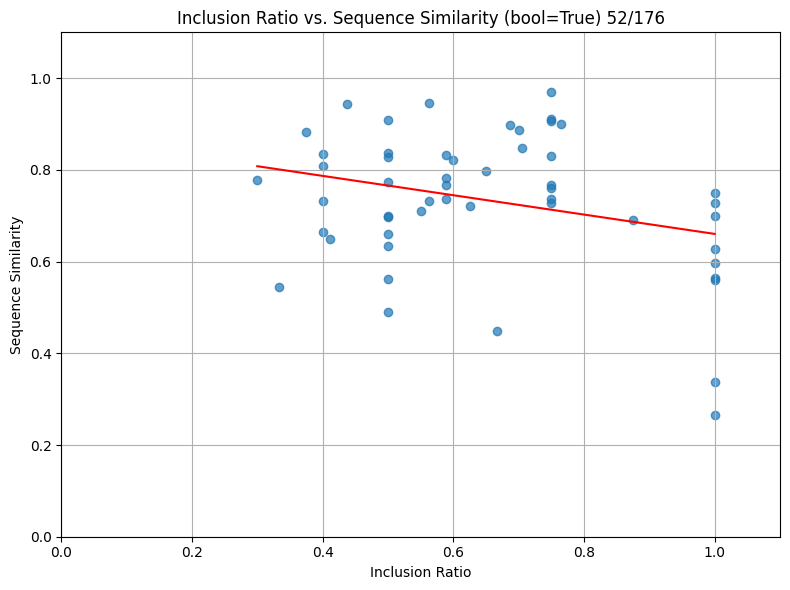

168 59


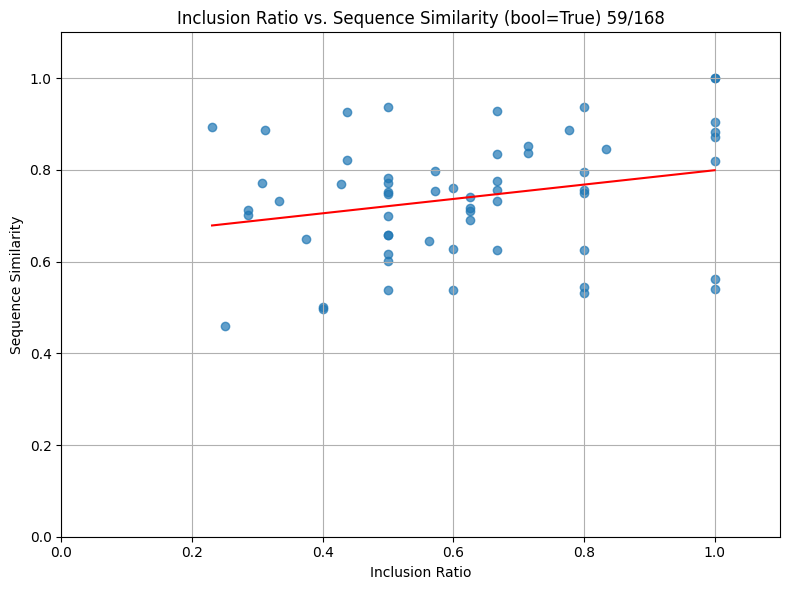

224 75


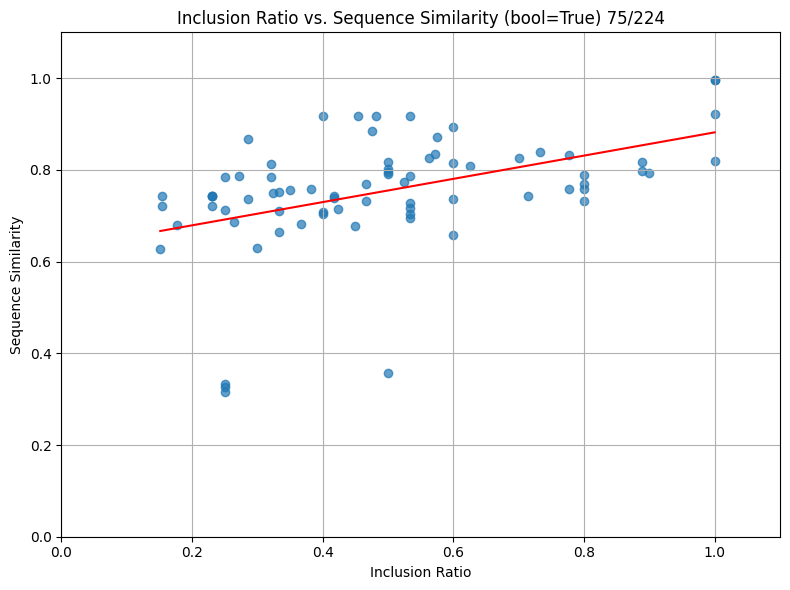

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

#======================
#interactive cursor hover
#======================
def plot_taxonomy_cursor(df:pd.DataFrame, mybool:bool):
    df = df.dropna(subset=['inclusion_ratio', 'taxonomy_similarity_sbert', 'taxonomy_boolean'])
    size1 = df.shape[0]
    filtered_df = df[df['taxonomy_boolean'] == mybool]
    size2 = filtered_df.shape[0]

    # Step 2: Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        filtered_df['inclusion_ratio'], 
        filtered_df['taxonomy_similarity_sbert'], 
        alpha=0.7
    )

    ax.set_xlabel('Inclusion Ratio')
    ax.set_ylabel('Taxonomy Similarity')
    ax.set_title(f'Inclusion Ratio vs. Taxonomy Similarity (Only where taxonomy_boolean={mybool}) {size2}/{size1}')

    # Polynomial fit
    N = 1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['taxonomy_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    ax.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')

    # Limits and layout
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    plt.tight_layout()

    # mplcursors for interactive tooltips
    cursor = mplcursors.cursor(sc, hover=True)
    
    @cursor.connect("add")
    def on_add(sel):
        idx = sel.index
        # Customize the tooltip content here
        sel.annotation.set_text(
            f"x: {filtered_df['inclusion_ratio'].iloc[idx]:.2f}\n"
            f"y: {filtered_df['taxonomy_similarity_sbert'].iloc[idx]:.2f}\n"
            f"info: {filtered_df.get('source_uid', pd.Series(['N/A'] * size2)).iloc[idx]}"
        )

    plt.show()    
    print(filtered_df.shape[0])
    ffiltered_df = filtered_df[filtered_df['inclusion_ratio'] == 1]
    print(f"inclusion 1 with fails {ffiltered_df.shape[0]}")
    print(ffiltered_df['source_uid'].unique().tolist())
    print(ffiltered_df['idx'].unique().tolist())

def plot_sequence_cursor(df:pd.DataFrame, mybool:bool):
    df = df.dropna(subset=['inclusion_ratio', 'sequence_similarity_sbert', 'sequence_boolean'])
    filtered_df = df[df['sequence_boolean'] == mybool]
    size1 = df.shape[0]
    size2 = filtered_df.shape[0]
    print(size1, size2)

    # Step 2: Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        filtered_df['inclusion_ratio'], 
        filtered_df['sequence_similarity_sbert'], 
        alpha=0.7
    )

    ax.set_xlabel('Inclusion Ratio')
    ax.set_ylabel('Sequence Similarity')
    ax.set_title(f'Inclusion Ratio vs. Sequence Similarity (bool={mybool}) {size2}/{size1}')

    # Polynomial fit
    N = 1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['sequence_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    ax.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')

    # Limits and layout
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    plt.tight_layout()

    # mplcursors for interactive tooltips
    cursor = mplcursors.cursor(sc, hover=True)
    
    @cursor.connect("add")
    def on_add(sel):
        idx = sel.index
        # Customize the tooltip content here
        sel.annotation.set_text(
            f"x: {filtered_df['inclusion_ratio'].iloc[idx]:.2f}\n"
            f"y: {filtered_df['sequence_similarity_sbert'].iloc[idx]:.2f}\n"
            f"info: {filtered_df.get('source_uid', pd.Series(['N/A'] * size2)).iloc[idx]}"
        )
 

    plt.show()    

#======================
#non interactive
#======================
def plot_taxonomy(df):
    df = df.dropna(subset=['inclusion_ratio', 'taxonomy_similarity_sbert', 'taxonomy_boolean'])
    size1 = df.shape[0]
    # df = df.dropna()
    mybool = True
    filtered_df = df[df['taxonomy_boolean'] == mybool]
    size2 = filtered_df.shape[0]
    print(filtered_df.shape[0])
    # Step 2: Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_df['inclusion_ratio'], filtered_df['taxonomy_similarity_sbert'], alpha=0.7)
    plt.xlabel('Inclusion Ratio')
    plt.ylabel('Taxonomy Similarity')
    plt.title(f'Inclusion Ratio vs. Taxonomy Similarity (Only where taxonomy_boolean={mybool}) {size2}/{size1}')


    #Generate smooth x values for curve plotting
    N=1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['taxonomy_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')


    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)  

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    

def plot_sequence(df):
    df = df.dropna(subset=['inclusion_ratio', 'sequence_similarity_sbert', 'sequence_boolean'])
    size1 = df.shape[0]
    mybool = True
    filtered_df = df[df['sequence_boolean'] == mybool]
    size2 = filtered_df.shape[0]

    # filtered_df = df

    # Step 2: Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_df['inclusion_ratio'], filtered_df['sequence_similarity_sbert'], alpha=0.7)
    plt.xlabel('Inclusion Ratio')
    plt.ylabel('Sequence Similarity')
    plt.title(f'Inclusion Ratio vs. Sequence Similarity (Only where sequence_boolean={mybool} {size2}/{size1})')

    # Generate smooth x values for curve plotting
    N=1
    coeffs = np.polyfit(filtered_df['inclusion_ratio'], filtered_df['sequence_similarity_sbert'], deg=N)
    poly_func = np.poly1d(coeffs)
    x_smooth = np.linspace(filtered_df['inclusion_ratio'].min(), filtered_df['inclusion_ratio'].max(), 200)
    y_smooth = poly_func(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', label=f'{N}° polynomial fit')

    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)  

    plt.grid(True)
    plt.tight_layout()
    plt.show()    


# plot_taxonomy_cursor(df_rag, True)
# plot_taxonomy_cursor(df_rag, False)
# plot_taxonomy_cursor(df_norag, True)
# plot_taxonomy_cursor(df_norag, False)
# plot_taxonomy_cursor(df_norag)

# plot_taxonomy_cursor(df_rag_gold, True)
# plot_taxonomy_cursor(df_rag_gold, False)
# plot_taxonomy_cursor(df_norag_gold, True)
# plot_taxonomy_cursor(df_norag_gold, False)

# plot_taxonomy_cursor(df_rag_silver, True)
# plot_taxonomy_cursor(df_rag_silver, False)
# plot_taxonomy_cursor(df_norag_silver, True)
# plot_taxonomy_cursor(df_norag_silver, False)

# plot_taxonomy_cursor(df_rag_bronze, True)
# plot_taxonomy_cursor(df_rag_bronze, False)
# plot_taxonomy_cursor(df_norag_bronze, True)
# plot_taxonomy_cursor(df_norag_bronze, False)



# plot_sequence_cursor(df_rag, True)
# plot_sequence_cursor(df_norag, True)
# plot_sequence_cursor(df_1direct, False)
# plot_sequence_cursor(df_1goalmediation, True)


# plot_sequence_cursor(df_rag_gold, True)
# plot_sequence_cursor(df_rag_gold, False)
# plot_sequence_cursor(df_norag_gold, True)
# plot_sequence_cursor(df_norag_gold, False)
plot_sequence_cursor(df_1goalmediation_gold, True)
# plot_sequence_cursor(df_1goalmediation_gold, False)

# plot_sequence_cursor(df_rag_silver, True)
# plot_sequence_cursor(df_rag_silver, False)
# plot_sequence_cursor(df_norag_silver, True)
plot_sequence_cursor(df_1goalmediation_silver, True)
# plot_sequence_cursor(df_1goalmediation_silver, False)


# plot_sequence_cursor(df_rag_bronze, True)
# plot_sequence_cursor(df_rag_bronze, False)
# plot_sequence_cursor(df_norag_bronze, True)
# plot_sequence_cursor(df_norag_bronze, False)
plot_sequence_cursor(df_1goalmediation_bronze, True)
# plot_sequence_cursor(df_1goalmediation_bronze, False)





In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mplcursors

# Dummy DataFrame
df = pd.DataFrame({
    'inclusion_ratio': np.random.rand(10),
    'sequence_similarity_sbert': np.random.rand(10),
    'taxonomy_boolean': [True] * 10,
    'source_uid': [f"Item {i}" for i in range(40, 50)]
})

# plot_sequence_cursor(df)

In [ ]:

def filter_taxdf(df:dict):
    size0 = df.shape[0]
    df = df.dropna(subset=['inclusion_ratio', 'taxonomy_similarity_sbert', 'taxonomy_boolean', 'sequence_similarity_sbert', 'sequence_boolean'])
    size1 = df.shape[0]
    filtered_df = df[df['taxonomy_boolean'] == True]
    size2 = filtered_df.shape[0]
    filtered_df = filtered_df[filtered_df['sequence_boolean'] == True]
    size3 = filtered_df.shape[0]

    print(f"{size0} {size1} {size2} {size3}")
    return filtered_df

filtered_df_rag = filter_taxdf(df_rag)
filtered_df_norag = filter_taxdf(df_norag)

def filter_by_sbert(df:dict, sbertitem:str, min:float, max:float):
    filtered_df = df[df[sbertitem] > min]
    filtered_df = filtered_df[filtered_df[sbertitem] <= max]
    size = filtered_df.shape[0]
    # print(f"{size} : {list(filtered_df['source_uid'])}")
    print("idx")
    filtered_df = filtered_df.sort_values(by='idx')
    for i in range(size):
        print(f"idx: {filtered_df.iloc[i]['idx']}, {filtered_df.iloc[i]['inclusion_ratio']:.2f}, source_uid: {filtered_df.iloc[i]['source_uid']}, target_uid: {filtered_df.iloc[i]['target_uid']}")

    print("inclusion_ratio")
    filtered_df = filtered_df.sort_values(by='inclusion_ratio')
    for i in range(size):
        print(f"idx: {filtered_df.iloc[i]['idx']}, {filtered_df.iloc[i]['inclusion_ratio']:.2f}, source_uid: {filtered_df.iloc[i]['source_uid']}, target_uid: {filtered_df.iloc[i]['target_uid']}")

    return filtered_df

def get_common_dict(dict1:dict, dict2:dict, k:str):
    '''
    k:keyname
    '''
    return {k: dict1[k] for k in dict1 if k in dict2 and dict1[k] == dict2[k]}



# find passed true rags and lookat same index
common_idx = set(filtered_df_rag['idx']) & set(filtered_df_norag['idx'])
df_common = filtered_df_rag[filtered_df_rag['idx'].isin(common_idx)]
print(df_common.shape[0])
df_common1 = filter_by_sbert(df_common, 'taxonomy_similarity_sbert', 0.95, 1.0)
df_common2 = filter_by_sbert(df_common, 'taxonomy_similarity_sbert', 0.90, 0.95)


# # for 1.0 both seq and taxonomy survives
# print("sbert 1.0")
# filtered_df_rag_tax = filter_by_sbert(df_rag, 'taxonomy_similarity_sbert', 0.95, 1.0)
# filtered_df_norag_tax = filter_by_sbert(df_norag, 'taxonomy_similarity_sbert', 0.95,1.0)
# filtered_df_rag_seq = filter_by_sbert(df_rag, 'sequence_similarity_sbert', 0.95,1.0)
# filtered_df_norag_seq = filter_by_sbert(df_norag, 'sequence_similarity_sbert', 0.95,1.0)

# common_rag = list(set(list(filtered_df_rag_tax['source_uid'])) & set(list(filtered_df_rag_seq['source_uid'])))
# common_norag = list(set(list(filtered_df_norag_tax['source_uid'])) & set(list(filtered_df_norag_seq['source_uid'])))
# more_common_list1 = list(set(common_rag) & set(common_norag))
# print(f"{len(common_rag)} {common_rag}")
# print(f"{len(common_norag)} {common_norag}")
# print(f"{len(more_common_list1)} {more_common_list1}")

# print("sbert 0.65-0.75")
# filtered_df_rag_tax = filter_by_sbert(df_rag, 'taxonomy_similarity_sbert', 0.85, 0.9)
# filtered_df_norag_tax = filter_by_sbert(df_norag, 'taxonomy_similarity_sbert', 0.85, 0.9)
# filtered_df_rag_seq = filter_by_sbert(df_rag, 'sequence_similarity_sbert', 0.85, 0.9)
# filtered_df_norag_seq = filter_by_sbert(df_norag, 'sequence_similarity_sbert', 0.85, 0.9)

# common_rag = list(set(list(filtered_df_rag_tax['source_uid'])) & set(list(filtered_df_rag_seq['source_uid'])))
# common_norag = list(set(list(filtered_df_norag_tax['source_uid'])) & set(list(filtered_df_norag_seq['source_uid'])))
# more_common_list2 = list(set(common_rag) & set(common_norag))
# print(f"{len(common_rag)} {common_rag}")
# print(f"{len(common_norag)} {common_norag}")
# print(f"{len(more_common_list2)} {more_common_list2}")

# print("sbert 0.5-0.5")
# filtered_df_rag_tax = filter_by_sbert(df_rag, 'taxonomy_similarity_sbert', 0.8,0.85)
# filtered_df_norag_tax = filter_by_sbert(df_norag, 'taxonomy_similarity_sbert', 0.8,0.85)
# filtered_df_rag_seq = filter_by_sbert(df_rag, 'sequence_similarity_sbert', 0.8,0.85)
# filtered_df_norag_seq = filter_by_sbert(df_norag, 'sequence_similarity_sbert', 0.8,0.85)

# common_rag = list(set(list(filtered_df_rag_tax['source_uid'])) & set(list(filtered_df_rag_seq['source_uid'])))
# common_norag = list(set(list(filtered_df_norag_tax['source_uid'])) & set(list(filtered_df_norag_seq['source_uid'])))
# more_common_list3 = list(set(common_rag) & set(common_norag))
# print(f"{len(common_rag)} {common_rag}")
# print(f"{len(common_norag)} {common_norag}")
# print(f"{len(more_common_list3)} {more_common_list3}")
# # find uid that made through both booleans


568 555 202 121
568 525 177 109
44
idx
idx: 13, 0.75, source_uid: 026dac2d-2ab3-4f9c-9e1d-6198db4fb080, target_uid: 2bc7d6fa-a02e-4367-b316-d6b4e8a2ce3f
idx: 28, 0.50, source_uid: 14bcb17c-f70a-41d5-b10d-294388084dfc, target_uid: 2da5c1ee-bd40-406d-83a7-2f3d93293949
idx: 34, 0.44, source_uid: 1a894d3c-b3ef-448a-a3de-2b38677cef36, target_uid: 2f46d1e6-2a85-4d46-b955-10c2eded661c
idx: 71, 0.35, source_uid: 2978ddbc-cdc9-4bfa-9a7c-4bf056904010, target_uid: 35080724-6604-401c-8b06-19b7cece3d45
idx: 113, 0.50, source_uid: 2f46d1e6-2a85-4d46-b955-10c2eded661c, target_uid: 487d752c-6e22-43e3-9c08-627bc2a6c6d4
idx: 114, 0.40, source_uid: 2f46d1e6-2a85-4d46-b955-10c2eded661c, target_uid: 487d752c-6e22-43e3-9c08-627bc2a6c6d4
idx: 213, 0.71, source_uid: 543e4c99-5d9f-407d-be75-c397d633fe56, target_uid: 737e9619-7768-407c-8a4f-6fe1e8d61f04
idx: 214, 0.71, source_uid: 543e4c99-5d9f-407d-be75-c397d633fe56, target_uid: 737e9619-7768-407c-8a4f-6fe1e8d61f04
idx: 229, 0.57, source_uid: 56fe0c73-77c4-40d

In [ ]:
%history

%matplotlib qt
import sys
import os
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
import mplcursors
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from bert_score import score

import pickle

sys.path.append(os.path.abspath('/root/project')) # add root path to sys.path
sys.path.append(os.path.abspath('/usr/local/lib/python3.10/dist-packages'))
from util import util_constants
from util import util_funcs
import f4_evaluate.evaluate_scene as evaluate_scene
import f1_init.database_init as database_init
import f1_init.agent_init as agent_init
import f1_init.constants_init as constants_init

#Computing similarity
import json
from sentence_transformers import SentenceTransformer
from bert_score import score
import numpy as np
from numpy.linalg import norm
import ast
import pandas as pd

#PATHS
PATH_CURR_FOLDER = os.path.abspath('') 
PATH_DATA_ANNOTATION = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_annotatio